# Predictive Analysis

In [1]:
%matplotlib inline
import pandas as pd; pd.options.display.float_format = '{:,.3f}'.format
import numpy as np
import seaborn as sns; sns.set_style("dark")
import matplotlib.pyplot as plt; plt.rcParams['figure.figsize'] = (8,6)
from IPython.display import display
from pprint import pprint

from sklearn.model_selection import train_test_split

from ml_tools import make_cross_validation, make_grid_search_clf, plot_roc_curve, make_grid_search_reg

## Data Preparation

We have the data for years 2014 and 2015. As we have seen in the previous section, the distribution of the different variables in both years differ sometimes largely from each other. For this reason we have decided not to take 2014 data for training and 2015 data from testing. Instead, we will draw a random sample from the merged dataset. The test sample is 25% of the size of the whole dataset. We have 11,316 examples in total, with 8,487 allocated to the training set and 2,829 extracted for testing purposes.<br/>
The objective is to design a predictive model which can then be used to optimise the multiplier of the estimated value. We operate by first selecting a model using KFold crossvalidation with 5 folds. Then we select the three best performing models to fine-tune their hyperparameters and boost the resulting score. The tuning of the hyperparameters is also done with a crossvalidation framework with 5 folds. We first define the range of possible parameters and then select the set of hyperparameters that maximise the evaluation metric.</br>
As discussed in the previous section, price related features have an exponential distribution. For this reason, we consider the logarithm of these values to design the model.

In [2]:
def load_data(filename):
    return pd.read_csv("data/" + filename)

data2014 = pd.read_csv('data/data2014.csv').assign(year=2014)
data2015 = pd.read_csv('data/data2015.csv').assign(year=2015)
data = pd.concat([data2014, data2015], axis=0).reset_index(drop=True)

target_name = "lmultiplier"
cols = ["multiplier", "EstValue", "StartPrice", "SP.EV", "Followers"]
log10 = pd.DataFrame(np.log10(data[cols].values), columns=list(map("l{}".format, cols)))
data = pd.concat([data, log10], axis=1).drop(cols, axis=1)
data.sample(5)

,LotNr,Allocate,Bank,Dealer,Liquidator,Volunteer,LotsSale,LotsCtgry,Forced,Duration,Morning,Evening,Afternoon,year,lmultiplier,lEstValue,lStartPrice,lSP.EV,lFollowers
5387,86,0,0,1,0,0,1426,159,0,38,0,0,1,2014,-0.067,1.544,1.398,-0.146,0.954
3969,240,0,0,1,0,0,955,343,0,244,0,0,1,2014,-0.049,2.146,2.097,-0.049,0.477
8327,58,0,0,1,0,0,721,354,0,461,0,0,1,2015,-0.135,2.176,2.000,-0.176,1.176
1877,30,0,0,1,0,0,1223,51,0,438,0,0,1,2014,-0.180,2.699,2.398,-0.301,1.000
6673,190,0,0,0,0,1,462,97,0,265,0,0,1,2014,0.243,1.301,1.000,-0.301,1.279


## Regression

Assumption:

$$(Start Price_i, Duration_i, Estimated Value_i, Period_i) \rightarrow Followers_i \rightarrow Multiplier$$

### Model selection

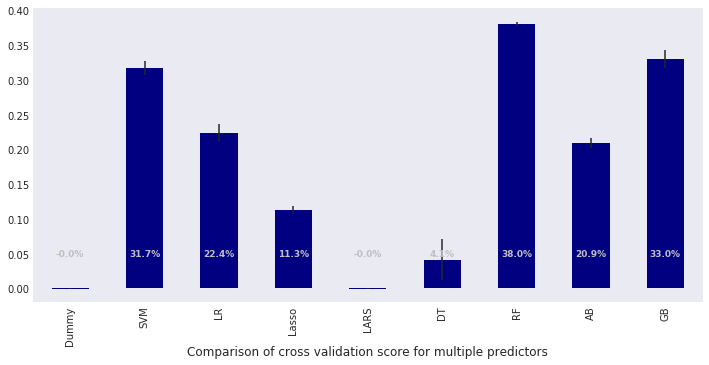

In [3]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, LassoLars
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score

scoring = "r2"

models = [
    
    ("Dummy", DummyRegressor(strategy="mean")),
    ("SVM", SVR()), 
    ("LR", LinearRegression()),
    ("Lasso", Lasso()),
    ("LARS", LassoLars()),
    ("DT", DecisionTreeRegressor()), 
    ("RF", RandomForestRegressor()),
    ("AB", AdaBoostRegressor()),
    ("GB", GradientBoostingRegressor())
    
]

followers = "lFollowers"
X, iv, y = data.drop([target_name, followers], axis=1), data[followers], data[target_name]
X_train, X_test, iv_train, iv_test, y_train, y_test = train_test_split(X, iv, y)

cv_results = make_cross_validation(models, scoring, X_train, iv_train)

### Hyperparameters tuning


LinearRegression:

	RMSE: 0.31
	R2 Score (Train set): 22.39%
	R2 Score (Test set): 20.74%

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True) 

####################################################################################################

RandomForestRegressor:

	RMSE: 0.30
	R2 Score (Train set): 28.78%
	R2 Score (Test set): 28.72%

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features=9, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=70, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False) 

####################################################################################################

GradientBoostingRegressor:

	RMSE: 0.26
	R2 Score (Train set): 42.14%
	R2 Score (Test set): 45.74%

GradientBoostingRegressor(alpha=0.9, criterion='fried

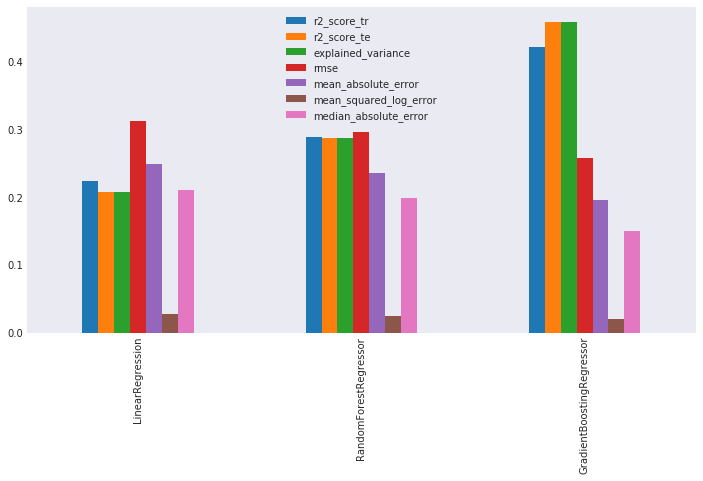

In [4]:
n_features = X_train.shape[1]

regressors = [
    ("LinearRegression", LinearRegression()), 
    ("RandomForestRegressor", RandomForestRegressor(n_estimators=70)),
    ("GradientBoostingRegressor", GradientBoostingRegressor(n_estimators=60, learning_rate=.1, max_features=9))
]

reg_params = {
    "LinearRegression": {
        "normalize": [True, False]
    },
    
    "RandomForestRegressor": {
        "criterion": ["mse", "mae"],
        "max_features": range(5, n_features, (n_features - 5) // 3), 
        "max_depth": range(3, 6, 2),
#         "min_samples_split": range(5, 101, 25),
#         "n_estimators": range(40, 80, 10)
    },
    
    "GradientBoostingRegressor": {
        "min_samples_split" :   range(5, 20, 3),
#         "max_features": range(5, n_features + 1, (n_features - 5) // 4),
        "max_depth": range(3, 16, 4),
#         "learning_rate": np.logspace(-2, 1, 4),
#         "n_estimators": range(40, 80, 10)

    },
}

best_models, results = make_grid_search_reg(regressors, reg_params, X_train, iv_train, X_test, iv_test)

In [5]:
gbr = best_models[-1]
coef = pd.DataFrame(index=X_train.columns)
coef["Feature Importances"] = gbr.feature_importances_
coef.sort_values("Feature Importances", ascending=False)

,Feature Importances
LotNr,0.458
lEstValue,0.112
LotsCtgry,0.104
Duration,0.088
lStartPrice,0.077
lSP.EV,0.070
LotsSale,0.052
year,0.009
Afternoon,0.006
Dealer,0.005


## Classification

### Preprocessing

Prepare data for classification

In [10]:
# bins = np.logspace(-2, 2, 5, base=2)
bins = np.linspace(0, 2, 3)

def cut(X, filter_values, log=False):
    if log: X = np.log2(X)
    X_cut = pd.cut(X, bins=filter_values)
    X_cut = X_cut.map(lambda x: np.argmax(filter_values > x.left) - 1)
    X_cut.loc[X_cut.isnull()] = X[X_cut.isnull()].map(lambda x: len(filter_values) - 2 if x > filter_values[-1] else 0)
    return X_cut

X_train, X_test = pd.concat([X_train, iv_train], axis=1), pd.concat([X_test, iv_test], axis=1)
# y_train_bins = cut(y_train, bins, log=False)
# y_test_bins = cut(y_test, bins)
y_train_bins = y_train.map(lambda x: 0 if x <= 0 else 1)
y_test_bins = y_test.map(lambda x: 0 if x <= 0 else 1)

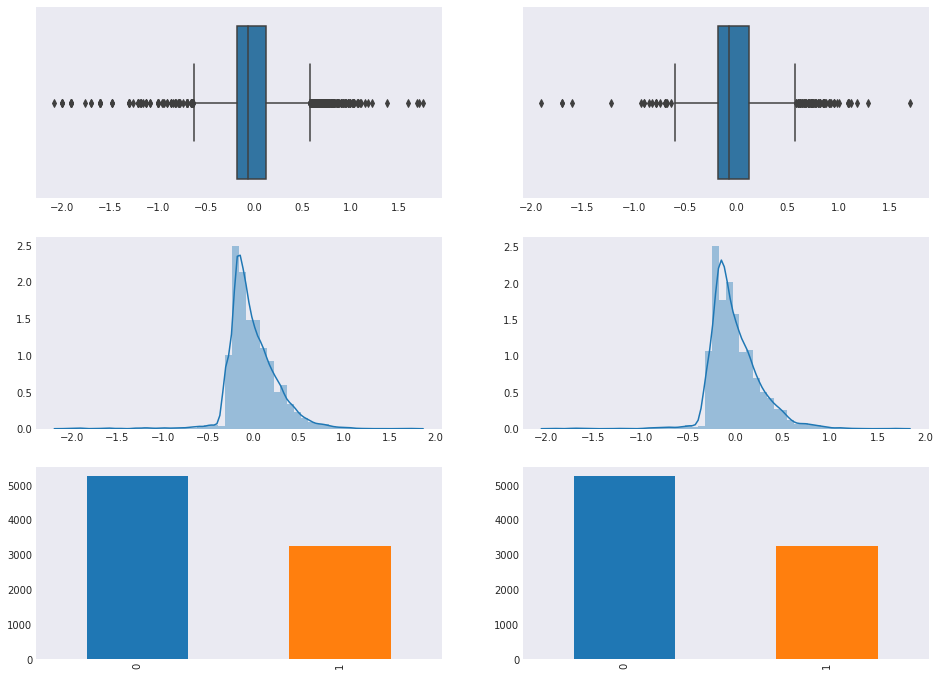

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(16,12))
for i, (series, series_bin) in enumerate(zip([y_train, y_test], [y_train_bins, y_train_bins])):
    sns.boxplot(series, ax=axs[0, i % 3])
    sns.distplot(series, ax=axs[1, i % 3])
    series_bin.value_counts().sort_index().plot.bar(ax=axs[2, i % 3])
    [ax.set_xlabel("") for ax in axs[:, i % 3]]

### Classification

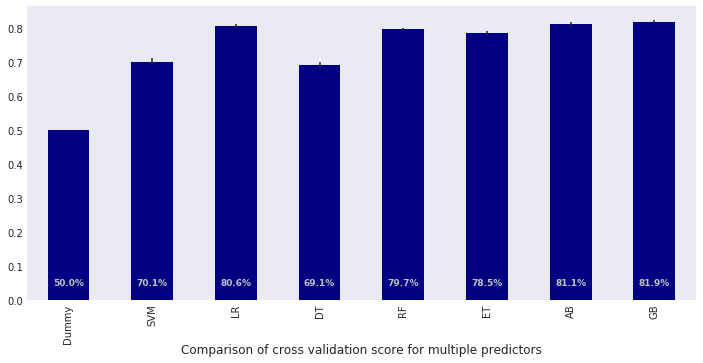

In [12]:
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)

scoring = "roc_auc"

models = [
    
    ("Dummy", DummyClassifier(strategy="most_frequent")),
    ("SVM", SVC()), 
    ("LR", LogisticRegression()),
    ("DT", DecisionTreeClassifier()), 
    ("RF", RandomForestClassifier()),
    ("ET", ExtraTreesClassifier()),
    ("AB", AdaBoostClassifier()),
    ("GB", GradientBoostingClassifier())
    
]

cv_results = make_cross_validation(models, scoring, X_train, y_train_bins)


LogisticRegression:

	Accuracy: 74.94%
	AUC Score (Train set): 74.62%
	AUC Score (Test set): 72.27%

             precision    recall  f1-score   support

          0       0.77      0.84      0.80      1743
          1       0.70      0.61      0.65      1086

avg / total       0.75      0.75      0.75      2829

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

####################################################################################################

AdaBoostClassifier:

	Accuracy: 76.39%
	AUC Score (Train set): 75.76%
	AUC Score (Test set): 73.84%

             precision    recall  f1-score   support

          0       0.79      0.85      0.82      1743
          1       0.72      0.63      0.67      1086

avg / total       0.76      0.76      0.76      28

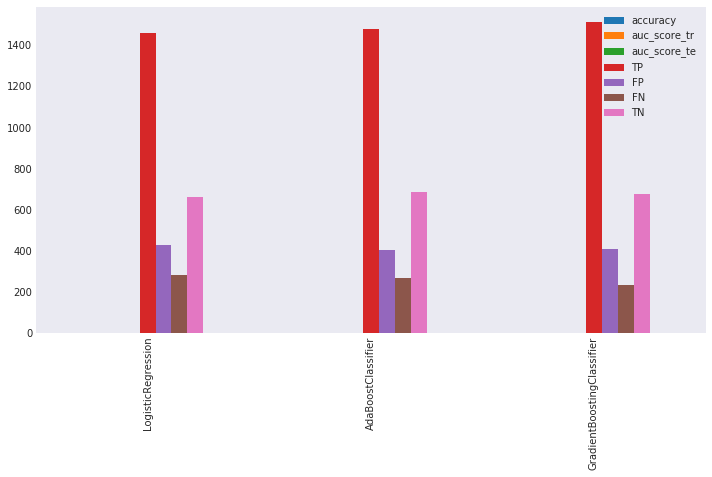

In [13]:
n_features = X_train.shape[1]

base_dt = DecisionTreeClassifier(criterion='entropy', splitter='random')  #max_features="auto", max_depth=None)

classifiers = [
    ("LogisticRegression", LogisticRegression()), 
    ("AdaBoostClassifier", AdaBoostClassifier(base_estimator=base_dt, learning_rate=0.01, n_estimators=60)),
    ("GradientBoostingClassifier", GradientBoostingClassifier(n_estimators=60, learning_rate=0.1))
]

clf_params = {
    "LogisticRegression": {
        "penalty": ["l1", "l2"], 
        "C": np.logspace(-3, 3, 7), 
        "class_weight":["balanced", None]
    },
    
    "AdaBoostClassifier": {
#         "base_estimator__criterion" : ["gini", "entropy"],
#         "base_estimator__splitter" :   ["best", "random"],
        "base_estimator__max_features": range(5, n_features + 1, (n_features - 5) // 4),
        "base_estimator__max_depth": range(3, 16, 4),
#         "learning_rate": np.logspace(-2, 1, 4),
#         "n_estimators": range(40, 80, 10)
    },
    
    "GradientBoostingClassifier": {
        "min_samples_split" :   range(3, 10, 3),
        "max_features": range(5, n_features + 1, (n_features - 5) // 4),
        "max_depth": range(3, 16, 4),
#         "learning_rate": np.logspace(-2, 1, 4),
#         "n_estimators": range(40, 80, 10)

    },
}

best_models, results = make_grid_search_clf(classifiers, clf_params, X_train, y_train_bins, X_test, y_test_bins)

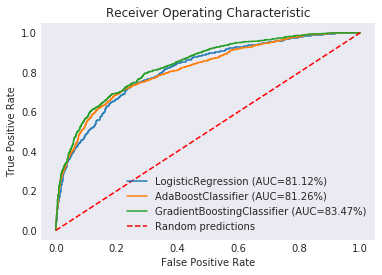

In [14]:
plot_roc_curve(classifiers, best_models, X_test, y_test_bins)

In [15]:
clf = best_models[-1]
coef = pd.DataFrame(index=X_train.columns)
coef["Feature Importances"] = clf.feature_importances_
coef.sort_values("Feature Importances", ascending=False)

,Feature Importances
LotNr,0.274
lFollowers,0.139
lFollowers,0.111
LotsCtgry,0.105
Duration,0.088
lSP.EV,0.084
lEstValue,0.077
lStartPrice,0.049
LotsSale,0.038
Forced,0.006


In [17]:
import pickle

def load_model(model_name):
    with open(model_name, 'rb') as f:
        model = pickle.load(f)
    return model

gbr = load_model("output/GradientBoostingRegressor.pkl")
gbc = load_model("output/GradientBoostingClassifier.pkl")

In [18]:
gbc

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=7,
              max_features=17, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=3,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)